<a href="https://colab.research.google.com/github/aishaa205/HTML_PROJECT_AISHA/blob/master/Water_Models_last_isa_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import Augmentor

pd.options.mode.chained_assignment = None # Turn off some annoying pandas warning

In [ ]:
# Setting seed for reproducible results

SEED = 42

tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_PATH = r"/content/drive/MyDrive/waters_models_last_isa /dataset_new.zip".replace(" ", "\ ") # Escaping White-spaces
!cp $DATASET_PATH .

In [ ]:
!unzip -qq dataset_new.zip

replace dataset_new/test/no_water/IMG-20231213-WA0223.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!tree -d dataset_new

dataset_new
├── output
│   ├── test
│   └── train
├── test
│   ├── no_water
│   └── water
└── train
    ├── no_water
    └── water

9 directories


In [ ]:
def load_images(path):
  images = []
  labels = []
  splits = []

  # Iterate over train and test data splits
  for split in os.listdir(path):
    split_path = os.path.join(path, split)

    # Iterate over each label (buildings, forest, etc..) in each split
    for label in os.listdir(split_path):
      label_path = os.path.join(split_path, label)

      # Iterate over each image in each label in each split
      for image in os.listdir(label_path):
        img_path = os.path.join(label_path, image)

        img = Image.open(img_path)

        images.append(img)
        labels.append(label)
        splits.append(split)

  return images, labels, splits

In [ ]:
#Data Augmentation for no water
image_dir = '/content/drive/MyDrive/waters_models_last_isa /dataset_new/train/no_water'

p=Augmentor.Pipeline(image_dir,output_directory=image_dir)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
p.flip_left_right(probability=0.5)
p.flip_top_bottom(probability=0.9)
p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=15)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.6)
p.greyscale(probability=1)
augmented_images = p.sample(100, multi_threaded=False)

In [ ]:
#Data Augmentation for  water
image_dir = '/content/drive/MyDrive/waters_models_last_isa /dataset_new/train/water'

p=Augmentor.Pipeline(image_dir,output_directory=image_dir)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
p.flip_left_right(probability=0.5)
p.flip_top_bottom(probability=0.9)
p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=15)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.6)
p.greyscale(probability=1)
augmented_images = p.sample(100, multi_threaded=False)


In [ ]:
PATH = 'dataset_new'
images, labels, splits = load_images(PATH)

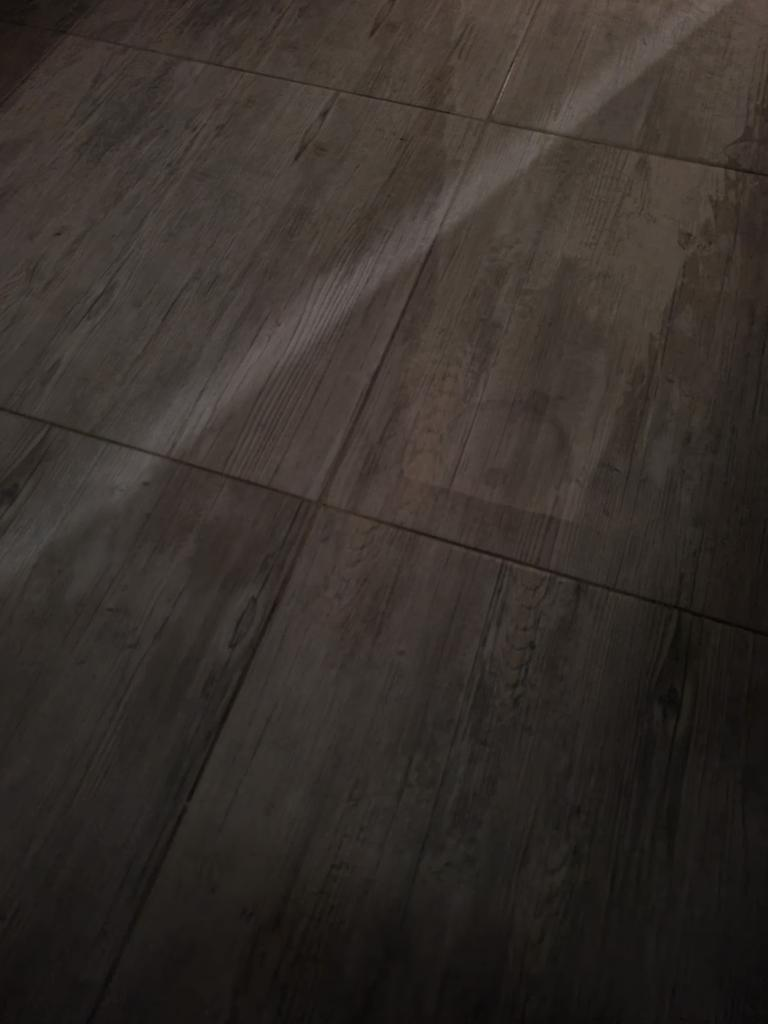

In [ ]:
images[0]

In [ ]:
print(labels[0])

no_water


In [ ]:
df = pd.DataFrame({"image": images, "label": labels, "split": splits})

In [ ]:
df.head()

,image,label,split
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,test
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,test
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,test
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,test
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,test


In [ ]:
df.split.value_counts()

split
train    83
test     32
Name: count, dtype: int64

In [ ]:
df_train = df[df['split'] == 'train']
df_test = df[df['split'] == 'test']

In [ ]:
df_train.label.value_counts()

label
no_water    44
water       39
Name: count, dtype: int64

In [ ]:
label2id = {"no_water": 0, "water": 1}
id2label = {0: 'no_water', 1: 'water'}
num_labels = 2

In [ ]:
df_train.head()

,image,label,split
32,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train
33,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train
34,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train
35,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train
36,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train


In [ ]:
# Map labels to ids

df_train['class'] = df_train['label'].map(label2id)
df_test['class'] = df_test['label'].map(label2id)

# shuffling samples
df_train = df_train.sample(frac=1, random_state=SEED, ignore_index=True)
df_test = df_test.sample(frac=1, random_state=SEED, ignore_index=True)

In [ ]:
df_train.head()

,image,label,split,class
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,no_water,train,0


In [ ]:
def fix_image(img):
  new_size = (224, 224)

  resized_img = img.resize(new_size)
  rgb_img = resized_img.convert("RGB")

  return np.array(rgb_img)

In [ ]:
x=fix_image(images[0])

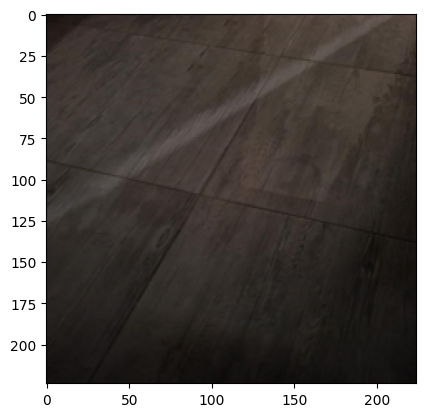

In [ ]:
plt.imshow(x)

In [ ]:
# import tensorflow as tf
# import tensorflow_datasets as tfds

# from tensorflow.keras import layers

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip("horizontal_and_vertical"),
#   layers.RandomRotation(0.2),
# ])

In [ ]:
# # Add the image to a batch.
# image = tf.cast(tf.expand_dims(images, 0), tf.uint8)

In [ ]:
train_images = np.array([fix_image(img) for img in df_train['image'].to_list()])
test_images = np.array([fix_image(img) for img in df_test['image'].to_list()])

In [ ]:
train_labels = np.array([label for label in df_train['class'].to_list()])
test_labels = np.array([label for label in df_test['class'].to_list()])

In [ ]:
train_labels = to_categorical(train_labels, num_labels)
test_labels = to_categorical(test_labels, num_labels)

In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((83, 224, 224, 3), (83, 2), (32, 224, 224, 3), (32, 2))

### Load Vgg16 model

In [ ]:
base_model = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [ ]:
model = Sequential()

# Feature Extraction Stage
model.add(base_model)

# Classification Stage
# Construct the head of the model that will be placed on top of the base model
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_labels, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1605696   
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 16320514 (62.26 MB)
Trainable params: 16320514 (62.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# # Pre-process the images according to vgg16 model requirements
train_images = keras.applications.vgg16.preprocess_input(train_images)
test_images = keras.applications.vgg16.preprocess_input(test_images)

In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((83, 224, 224, 3), (83, 2), (32, 224, 224, 3), (32, 2))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 8
epochs = 20

history = model.fit(x=train_images, y=train_labels, validation_data=(test_images, test_labels), batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/20
11/11 [==============================] - 6s 183ms/step - loss: 13.8806 - accuracy: 0.4458 - val_loss: 0.7269 - val_accuracy: 0.3750
Epoch 2/20
11/11 [==============================] - 2s 159ms/step - loss: 0.7454 - accuracy: 0.4940 - val_loss: 2.0695 - val_accuracy: 0.5938
Epoch 3/20
11/11 [==============================] - 2s 146ms/step - loss: 1.2357 - accuracy: 0.6386 - val_loss: 0.7202 - val_accuracy: 0.3125
Epoch 4/20
11/11 [==============================] - 2s 142ms/step - loss: 0.8036 - accuracy: 0.5301 - val_loss: 0.7176 - val_accuracy: 0.4062
Epoch 5/20
11/11 [==============================] - 2s 155ms/step - loss: 0.6860 - accuracy: 0.5783 - val_loss: 0.7426 - val_accuracy: 0.5625
Epoch 6/20
11/11 [==============================] - 2s 142ms/step - loss: 0.6810 - accuracy: 0.5663 - val_loss: 0.7151 - val_accuracy: 0.4375
Epoch 7/20
11/11 [==============================] - 2s 142ms/step - loss: 0.6839 - accuracy: 0.6145 - val_loss: 0.7622 - val_accuracy: 0.5938
Epoch

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(test_images, test_labels)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

1/1 [==============================] - 0s 466ms/step - loss: 0.7207 - accuracy: 0.4062
Validation Loss: 0.72071373462677
Validation Accuracy: 40.62%


In [ ]:
model.save('finetuned-model.keras')

In [ ]:
model = keras.models.load_model('finetuned-model.keras')

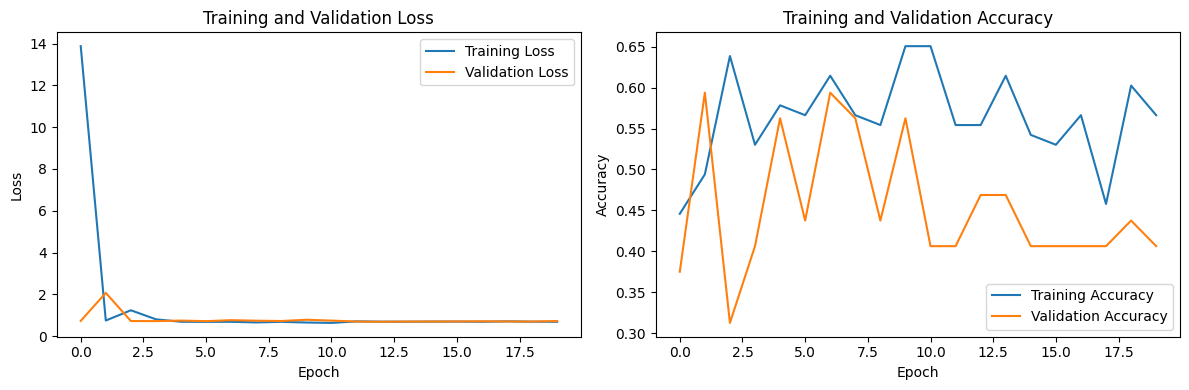

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predictions on the validation set
val_predictions = model.predict(test_images)
val_predictions_classes = np.argmax(val_predictions, axis=-1)

# Convert one-hot encoded labels back to integers
val_true_classes = np.argmax(test_labels, axis=-1)

1/1 [==============================] - 0s 184ms/step


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true=val_true_classes, y_pred=val_predictions_classes, target_names=list(label2id)))

Classification Report:
              precision    recall  f1-score   support

    no_water       0.40      0.92      0.56        13
       water       0.50      0.05      0.10        19

    accuracy                           0.41        32
   macro avg       0.45      0.49      0.33        32
weighted avg       0.46      0.41      0.28        32



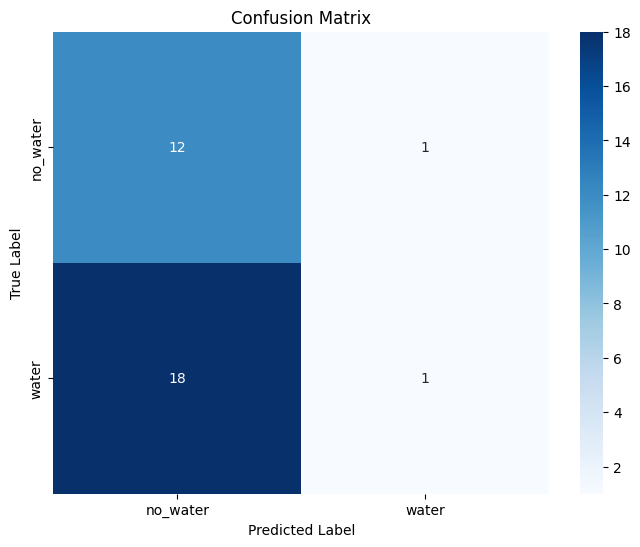

In [ ]:
# Confusion Matrix
cm = confusion_matrix(val_true_classes, val_predictions_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label2id), yticklabels=list(label2id))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### load rasnet50 model

In [ ]:
base_model_1 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Freeze the layers in the base model so they will not be updated during the first training process (Transfer Learning)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
resnet_model = Sequential()

# Feature Extraction Stage
resnet_model.add(base_model_1)

# Classification Stage
# Construct the head of the model that will be placed on top of the base model
resnet_model.add(Flatten())
resnet_model.add(Dense(units=64, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(units=num_labels, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                6422592   
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 30010434 (114.48 MB)
Trainable params: 29957314 (114.28 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# Pre-process the images according to EfficientNet's model requirements
train_images = keras.applications.resnet50.preprocess_input(train_images)
test_images = keras.applications.resnet50.preprocess_input(test_images)

In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((83, 224, 224, 3), (83, 2), (32, 224, 224, 3), (32, 2))

In [ ]:
# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 16
epochs = 20

history_rasnet = resnet_model.fit(x=train_images, y=train_labels, validation_data=(test_images, test_labels), batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = resnet_model.evaluate(test_images, test_labels)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

In [ ]:
model.save('finetuned-model.keras')

In [ ]:
model_rasnet = keras.models.load_model('finetuned-model.keras')

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_rasnet.history['loss'], label='Training Loss')
plt.plot(history_rasnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_rasnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_rasnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predictions on the validation set
val_predictions = model.predict(test_images)
val_predictions_classes = np.argmax(val_predictions, axis=-1)

# Convert one-hot encoded labels back to integers
val_true_classes = np.argmax(test_labels, axis=-1)

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true=val_true_classes, y_pred=val_predictions_classes, target_names=list(label2id)))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(val_true_classes, val_predictions_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label2id), yticklabels=list(label2id))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Load InceptionV3 model  

In [ ]:
base_model = keras.applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

NameError: name 'keras' is not defined

In [ ]:
# Freeze the layers in the base model so they will not be updated during the first training process (Transfer Learning)
for layer in base_model.layers:
    layer.trainable = False

NameError: name 'base_model' is not defined

In [ ]:
model_InceptionV3 = Sequential()

# Feature Extraction Stage
model_InceptionV3.add(base_model)

# Classification Stage
# Construct the head of the model that will be placed on top of the base model
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(units=64, activation='relu'))
model_InceptionV3.add(Dropout(0.5))
model_InceptionV3.add(Dense(units=num_labels, activation='softmax'))

In [ ]:
model_InceptionV3.summary()

In [ ]:
# Pre-process the images according to EfficientNet's model requirements
train_images = keras.applications.inception_v3.preprocess_input(train_images)
test_images = keras.applications.inception_v3.preprocess_input(test_images)

In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

In [ ]:
# Compile the model
model_InceptionV3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 16
epochs = 20

history_2 = model_InceptionV3.fit(x=train_images, y=train_labels, validation_data=(test_images, test_labels), batch_size=batch_size, epochs=epochs, shuffle=True)

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(test_images, test_labels)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

In [ ]:
model.save('finetuned-model.keras')

In [ ]:
model_3 = keras.models.load_model('finetuned-model.keras')

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predictions on the validation set
val_predictions = model.predict(test_images)
val_predictions_classes = np.argmax(val_predictions, axis=-1)

# Convert one-hot encoded labels back to integers
val_true_classes = np.argmax(test_labels, axis=-1)

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true=val_true_classes, y_pred=val_predictions_classes, target_names=list(label2id)))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(val_true_classes, val_predictions_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label2id), yticklabels=list(label2id))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()